In [1]:
import os

In [2]:
import tensorflow as tf
tf.__version__


'1.15.0'

In [6]:
cur_dir = os.getcwd()
cur_dir

'C:\\Users\\psahai\\DataScience\\ml-rooftop-analysis\\ml-rooftop-analysis-master\\tmp\\rooftop_crops\\others'

In [3]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import keras

Using TensorFlow backend.


In [11]:
import pathlib
data_dir = pathlib.Path(cur_dir)
data_dir

WindowsPath('C:/Users/psahai/DataScience/ml-rooftop-analysis/ml-rooftop-analysis-master/tmp/rooftop_crops/others')

In [12]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

18684

In [21]:
figure_names = list([item.name for item in data_dir.glob('*/*.jpg') if item.name != "LICENSE.txt"])


In [22]:
import re
list1 = []
for i in figure_names:
    list1.append(" ".join(re.findall(".*(?=\.)", i)))

In [23]:
list2 = []
for i in list1:
    list2.append(" ".join(re.findall("[a-zA-Z]+", i)))

In [17]:
categories = set(list2)
categories

{'debris',
 'no annotations images',
 'pond',
 'stain',
 'veg over',
 'worn membrane'}

In [18]:
import pandas as pd
df = pd.DataFrame(list(zip(figure_names, list2)),
                 columns=['Image', 'category'])
df

,Image,category
0,debris_10025670_0.jpg,debris
1,debris_10025670_1.jpg,debris
2,debris_10025670_2.jpg,debris
3,debris_10027857.jpg,debris
4,debris_10031228_0.jpg,debris
...,...,...
18679,worn_membrane_9995299_6.jpg,worn membrane
18680,worn_membrane_9995343_0.jpg,worn membrane
18681,worn_membrane_9995343_1.jpg,worn membrane
18682,worn_membrane_9995343_2.jpg,worn membrane


In [19]:
dummies = pd.get_dummies(df['category'], prefix='category')
dummies

,category_debris,category_no annotations images,category_pond,category_stain,category_veg over,category_worn membrane
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
18679,0,0,0,0,0,1
18680,0,0,0,0,0,1
18681,0,0,0,0,0,1
18682,0,0,0,0,0,1


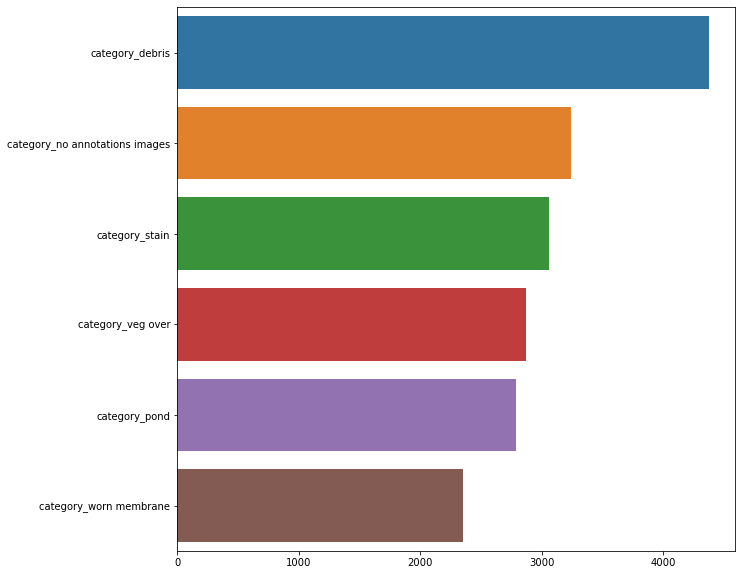

In [25]:
import seaborn as sns
target_counts = dummies.sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(10,10))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index);

# SAGEMAKER 

In [ ]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import tensorflow as tf
import sagemaker

from PIL import Image
from matplotlib import pyplot as plt

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

print('Libraries imported')

In [ ]:
def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

def get_annotations(file_path, annotations={}):
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        class_name = image_name.split('_')[:-1]
        class_name = '_'.join(class_name)
        image_name = image_name + '.jpg'
        
        annotations[image_name] = 'cat' if class_name[0] != class_name[0].lower() else 'dog'
    
    return annotations

In [ ]:
if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

In [ ]:
annotations = get_annotations('data/annotations/trainval.txt')
annotations = get_annotations('data/annotations/test.txt', annotations)

total_count = len(annotations.keys())
print('Total examples', total_count)

In [ ]:
classes = ['cat', 'dog']
sets = ['train', 'validation']
root_dir = 'custom_data'

if not os.path.isdir(root_dir):
    os.mkdir(root_dir)
    
for set_name in sets:
    if not os.path.isdir(os.path.join(root_dir, set_name)):
        os.mkdir(os.path.join(root_dir, set_name))
    for class_name in classes:
        folder = os.path.join(root_dir, set_name, class_name)
        if not os.path.isdir(folder):
            os.mkdir(folder)

In [ ]:
for image, class_name in annotations.items():
    target_set = 'validation' if random.randint(0, 99) < 20 else 'train'
    target_path = os.path.join(root_dir, target_set, class_name, image)
    shutil.copy(os.path.join('data/images/', image), target_path)

In [ ]:
sets_counts = {
    'train': 0,
    'validation': 0
}

for set_name in sets:
    for class_name in classes:
        path = os.path.join(root_dir, set_name, class_name)
        count = len(os.listdir(path))
        print(path, 'has', count, 'images')
        sets_counts[set_name] += count

print(sets_counts)

# Default CNN Model

In [ ]:
%%writefile train.py

import tensorflow as tf
import argparse
import os
import json

def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet',
                                                       pooling='avg', input_shape=(128, 128, 3)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.layers[0].trainable = False
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
%%writefile -a train.py

def create_data_generators(root_dir, batch_size):
    train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        horizontal_flip=True,
        zoom_range=[0.8, 1.2],
        rotation_range=20
    ).flow_from_directory(
        os.path.join(root_dir, 'train'),
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    val_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    ).flow_from_directory(
        os.path.join(root_dir, 'validation'),
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    return train_data_generator, val_data_generator

In [ ]:
%%writefile -a train.py

if __name__ =='__main__':

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=3)
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--steps', type=int, default=int(5906/16))
    parser.add_argument('--val_steps', type=int, default=int(1443/16))

    # input data and model directories
    parser.add_argument('--model_dir', type=str)
    parser.add_argument('--sm-model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAINING'))

    args, _ = parser.parse_known_args()

    local_output_dir = args.sm_model_dir
    local_root_dir = args.train
    batch_size = args.batch_size
    
    model = create_model()
    train_gen, val_gen = create_data_generators(local_root_dir, batch_size)
    
    _ = model.fit(
        train_gen,
        epochs=args.epochs,
        steps_per_epoch=args.steps,
        validation_data=val_gen,
        validation_steps=args.val_steps
    )
    
    model.save(os.path.join(local_output_dir, 'model', '1'))    

In [ ]:
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket_name = 'awsml-dronbase-rooftop'
print('Uploading data to S3')
s3_data_path = sess.upload_data(path=root_dir, bucket=bucket_name, key_prefix='data')
print('Uploaded to',  s3_data_path)

In [ ]:
from sagemaker.tensorflow import TensorFlow

pets_estimator = TensorFlow(
    entry_point='train.py',
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    framework_version='2.1.0',
    py_version='py3',
    output_path='s3://awsml-dronbase-rooftop/'
    )

In [ ]:
from sagemaker.tensorflow import TensorFlow

pets_estimator = TensorFlow(
    entry_point='train.py',
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    framework_version='2.1.0',
    py_version='py3',
    output_path='s3://awsml-dronbase-rooftop/'
    )

# Optimized CNN Model

In [ ]:
%%writefile train2.py

import tensorflow as tf
import argparse
import os
import json

def create_model():
    mobile_net = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False)
    mobile_net.trainable=False
    
    num_layers = len(mobile_net.layers)
    for layer_index in range(int(num_layers - 0.33*num_layers),
                            num_layers ):
        mobile_net.layers[layer_index].trainable = True
        
    model = tf.keras.Sequential([mobile_net,
                                    tf.keras.layers.GlobalAveragePooling2D(),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(64),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Dense(1, activation='sigmoid')],)
    
    model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
    
    return model

In [ ]:
%%writefile -a train2.py

def create_data_generators(root_dir, batch_size):
    train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
        horizontal_flip=True,
        zoom_range=[0.8, 1.2],
        rotation_range=20
    ).flow_from_directory(
        os.path.join(root_dir, 'train'),
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    val_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
    ).flow_from_directory(
        os.path.join(root_dir, 'validation'),
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    return train_data_generator, val_data_generator

In [ ]:
%%writefile -a train2.py

if __name__ =='__main__':

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=3)
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--steps', type=int, default=int(5906/16))
    parser.add_argument('--val_steps', type=int, default=int(1443/16))

    # input data and model directories
    parser.add_argument('--model_dir', type=str)
    parser.add_argument('--sm-model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAINING'))

    args, _ = parser.parse_known_args()

    local_output_dir = args.sm_model_dir
    local_root_dir = args.train
    batch_size = args.batch_size
    
    model = create_model()
    train_gen, val_gen = create_data_generators(local_root_dir, batch_size)
    
    _ = model.fit(
        train_gen,
        epochs=args.epochs,
        steps_per_epoch=args.steps,
        validation_data=val_gen,
        validation_steps=args.val_steps
    )
    
    model.save(os.path.join(local_output_dir, 'model', '2'))   

In [ ]:
from sagemaker.tensorflow import TensorFlow

pets_estimator2 = TensorFlow(
    entry_point='train2.py',
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    framework_version='2.1.0',
    py_version='py3',
    output_path='s3://awsml-dronbase-rooftop/'
    )